In [1]:
import os
import sys
import pandas as pd 
import re
import numpy as np
from datetime import datetime,timezone,timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import FileLink, FileLinks

import matplotlib.pyplot as plt  # For plotting graphs 
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings 

In [2]:
order = pd.read_csv('order.csv')
print(order.info())
order.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29462 entries, 0 to 29461
Data columns (total 3 columns):
date    29462 non-null object
hour    29462 non-null int64
gmv     29462 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 690.6+ KB
None


,date,hour,gmv
0,2017-01-01,0,111278.0
1,2017-01-01,1,88291.0
2,2017-01-01,2,40808.0
3,2017-01-01,3,26895.0
4,2017-01-01,4,5930.0


In [3]:
train = order.copy()
train['date'] = pd.to_datetime(train.date,format='%Y-%m-%d') 
train = train[train['date'] <= '2019-12-31']
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26273 entries, 0 to 26272
Data columns (total 3 columns):
date    26273 non-null datetime64[ns]
hour    26273 non-null int64
gmv     26273 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 821.0 KB
None


,date,hour,gmv
0,2017-01-01,0,111278.0
1,2017-01-01,1,88291.0
2,2017-01-01,2,40808.0
3,2017-01-01,3,26895.0
4,2017-01-01,4,5930.0


### Feature Extraction

In [4]:
train['year']=train['date'].dt.year 
train['month']=train['date'].dt.month 
train['day']=train['date'].dt.day
    
train.head()

,date,hour,gmv,year,month,day
0,2017-01-01,0,111278.0,2017,1,1
1,2017-01-01,1,88291.0,2017,1,1
2,2017-01-01,2,40808.0,2017,1,1
3,2017-01-01,3,26895.0,2017,1,1
4,2017-01-01,4,5930.0,2017,1,1


In [5]:
train['day of week']=train['date'].dt.dayofweek 
temp = train['date']

# Values of 5 and 6 represents that the days are weekend.
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train['date'].apply(applyer) 
train['weekend']=temp2
train.head()

,date,hour,gmv,year,month,day,day of week,weekend
0,2017-01-01,0,111278.0,2017,1,1,6,1
1,2017-01-01,1,88291.0,2017,1,1,6,1
2,2017-01-01,2,40808.0,2017,1,1,6,1
3,2017-01-01,3,26895.0,2017,1,1,6,1
4,2017-01-01,4,5930.0,2017,1,1,6,1


C:\Users\Bhushan Agarwal\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


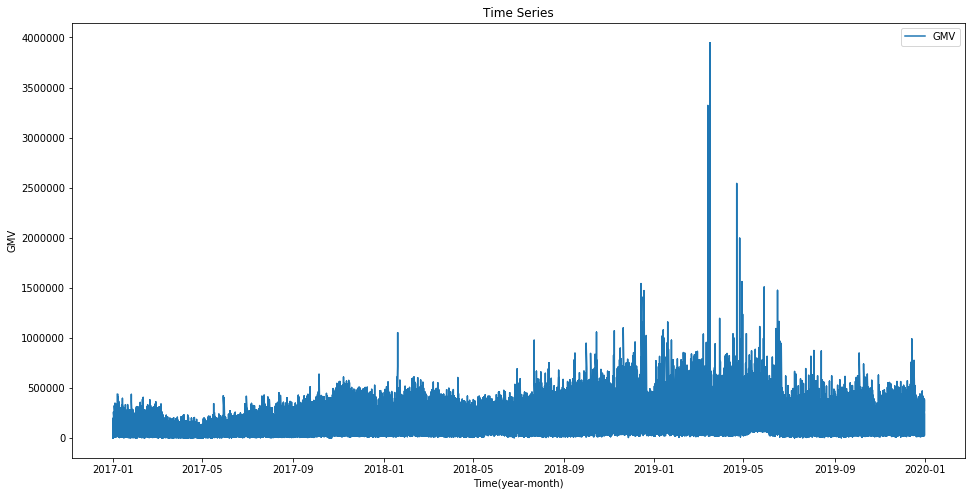

In [6]:
train.index = train['date'] # indexing the Datetime to get the time period on the x-axis. 
ts = train['gmv'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='GMV') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("GMV") 
plt.legend(loc='best')

### Expolratory Analysis

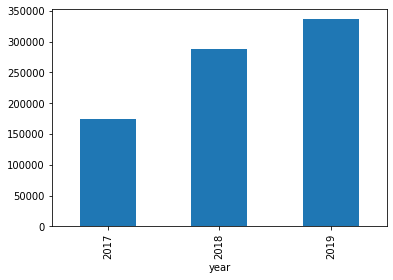

In [7]:
train.groupby('year')['gmv'].mean().plot.bar()

#### We see an linear growth in sales with respect to year

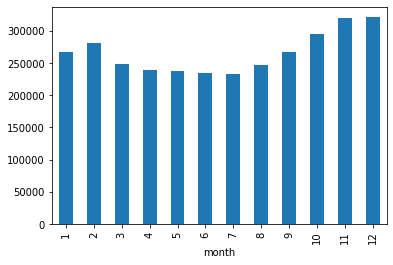

In [8]:
train.groupby('month')['gmv'].mean().plot.bar()

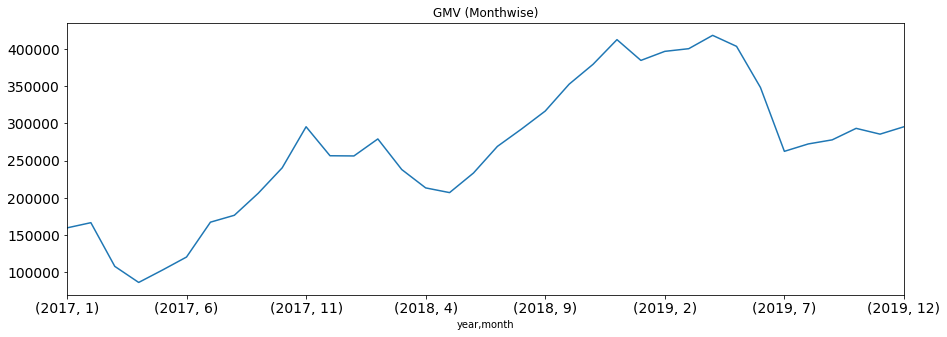

In [9]:
temp=train.groupby(['year', 'month'])['gmv'].mean() 
temp.plot(figsize=(15,5), title= 'GMV (Monthwise)', fontsize=14)

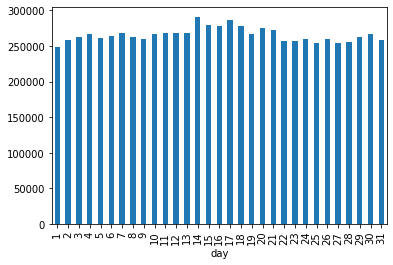

In [10]:
train.groupby('day')['gmv'].mean().plot.bar()

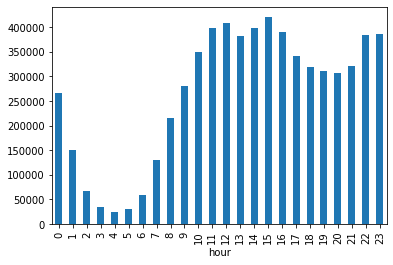

In [11]:
train.groupby('hour')['gmv'].mean().plot.bar()

#### It can be inferred that the peak traffic is at morning first half and then we see a decreasing trend till 8 PM. After that orders starts increasing again and peaks again between 11PM and 12 AM.

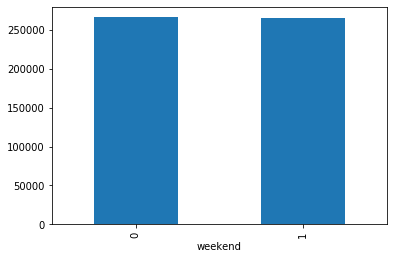

In [12]:
train.groupby('weekend')['gmv'].mean().plot.bar()

#### It can be inferred from the above plot that the traffic is similar on weekdays and weekends. Now we will try to look at the day wise passenger count.

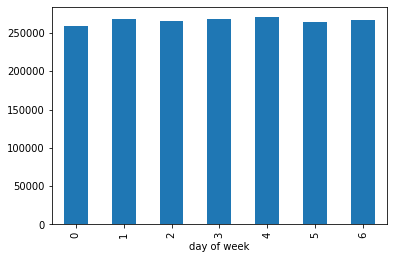

In [13]:
train.groupby('day of week')['gmv'].mean().plot.bar()

#### As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn. Let’s look at the hourly, daily, weekly and monthly time series.

In [14]:
train['date'] = pd.to_datetime(train['date'],format='%Y-%m-%Yd') 
train.index = train['date'] 
# # Hourly time series 
# hourly = train.resample('H').mean() 
# Converting to daily mean 
daily = train.resample('D').mean() 
# Converting to weekly mean 
weekly = train.resample('W').mean() 
# Converting to monthly mean 
monthly = train.resample('M').mean()

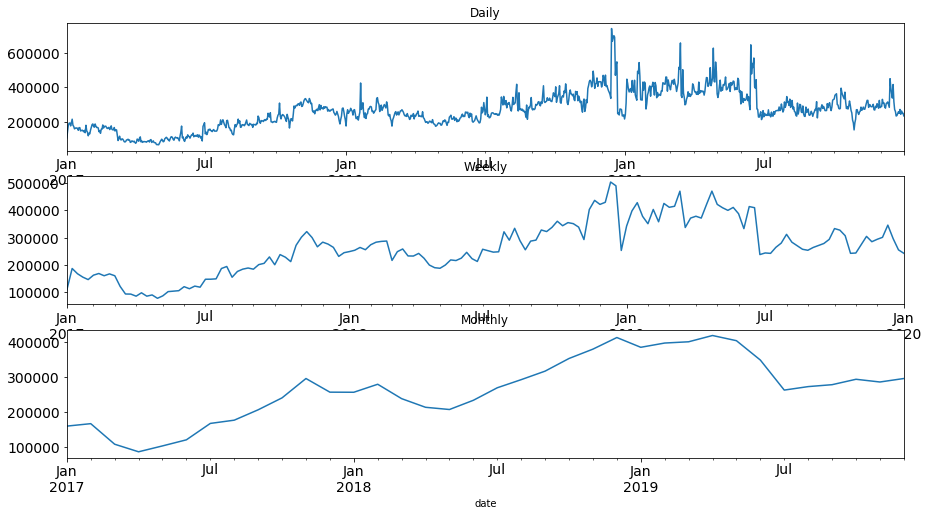

In [15]:
# Let’s look at the daily, weekly and monthly time series.

fig, axs = plt.subplots(3,1) 
daily.gmv.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[0]) 
weekly.gmv.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[1]) 
monthly.gmv.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[2]) 
plt.show()

#### We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis. But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [16]:
train['date'] = pd.to_datetime(train['date'],format='%Y-%m-%d') 
train.index = train['date'] 

# Converting to daily mean 
train = train.resample('D').mean()
train.head()

,hour,gmv,year,month,day,day of week,weekend
date,,,,,,,
2017-01-01,11.5,107361.750000,2017.0,1.0,1.0,6.0,1.0
2017-01-02,11.5,148183.416667,2017.0,1.0,2.0,0.0,0.0
2017-01-03,11.5,181919.333333,2017.0,1.0,3.0,1.0,0.0
2017-01-04,11.5,192685.625000,2017.0,1.0,4.0,2.0,0.0
2017-01-05,11.5,193427.158333,2017.0,1.0,5.0,3.0,0.0


### Splitting the data into training and validation part
Now we will divide our data in train and validation. We will make a model on the train part and predict on the validation part to check the accuracy of our predictions.

In [17]:
Train=train.ix['2017-01-01':'2019-09-30'] 
valid=train.ix['2019-10-01':'2019-12-31']

C:\Users\Bhushan Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\Bhushan Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


#### We have done time based validation here by selecting the last 3 months for the validation data and rest in the train data. If we would have done it randomly it may work well for the train dataset but will not work effectively on validation dataset. Lets understand it in this way: If we choose the split randomly it will take some values from the starting and some from the last years as well. It is similar to predicting the old values based on the future values which is not the case in real scenario. So, this kind of split is used while working with time related problems.

### Now we will look at how the train and validation part has been divided.

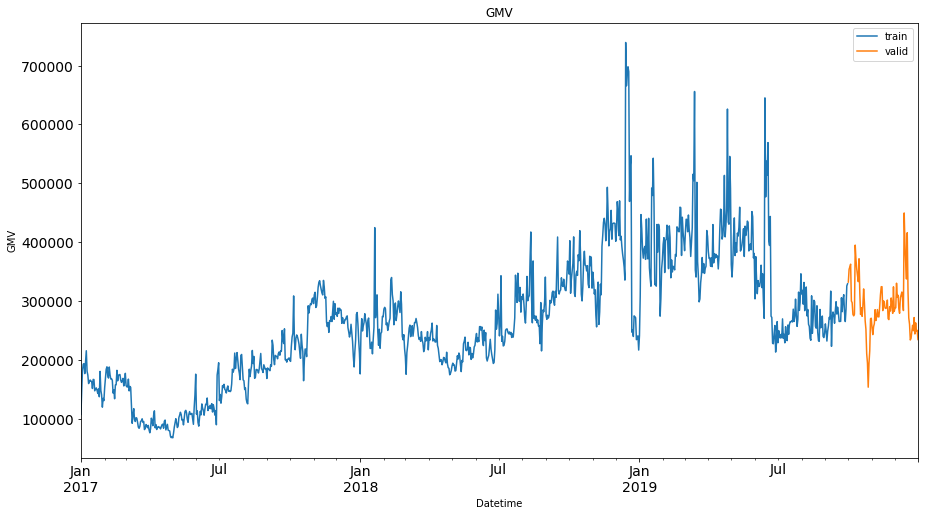

In [18]:
Train.gmv.plot(figsize=(15,8), title= 'GMV', fontsize=14, label='train') 
valid.gmv.plot(figsize=(15,8), title= 'GMV', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("GMV") 
plt.legend(loc='best') 
plt.show()

#### Here the blue part represents the train data and the orange part represents the validation data.

## Modeling Techniques

### 1. Naive Approach
In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction. Lets understand it with an example and an image:

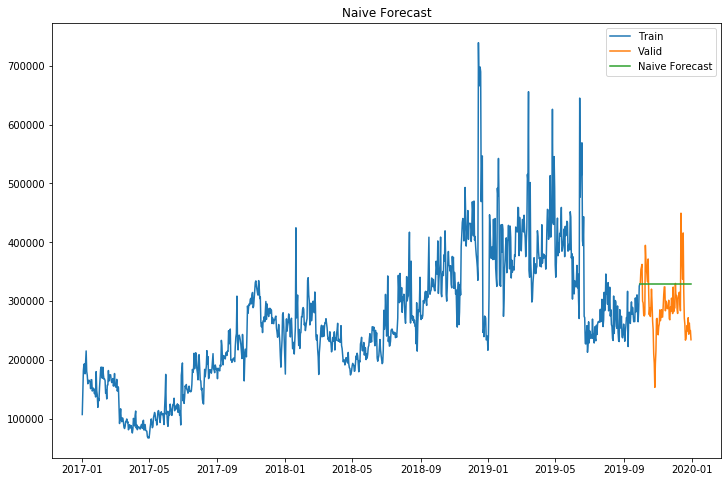

In [19]:
dd= np.asarray(Train.gmv) 
y_hat = valid.copy() 
y_hat['naive'] = dd[len(dd)-1] 
plt.figure(figsize=(12,8)) 
plt.plot(Train.index, Train['gmv'], label='Train') 
plt.plot(valid.index,valid['gmv'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

#### We can calculate how accurate our predictions are using rmse(Root Mean Square Error).
rmse is the standard deviation of the residuals.
Residuals are a measure of how far from the regression line data points are.
The formula for rmse is:
        rmse=sqrt∑i=1N1N(p−a)2

In [20]:
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.gmv, y_hat.naive)) 
print(rms)

60145.9804786715


### 2. Moving Average
In this technique we will take the average of the orders for last few time periods only.

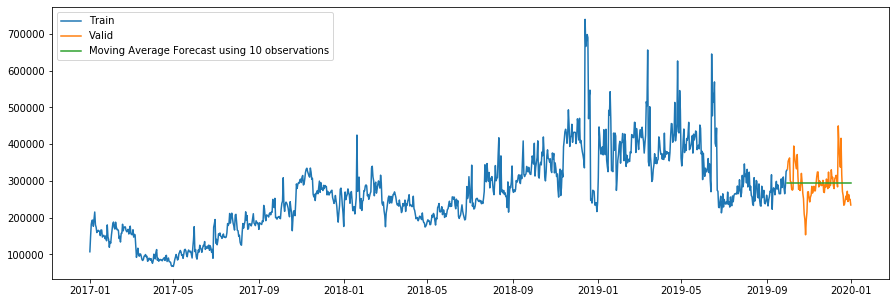

Root Mean Square Error: 46987.204005488966


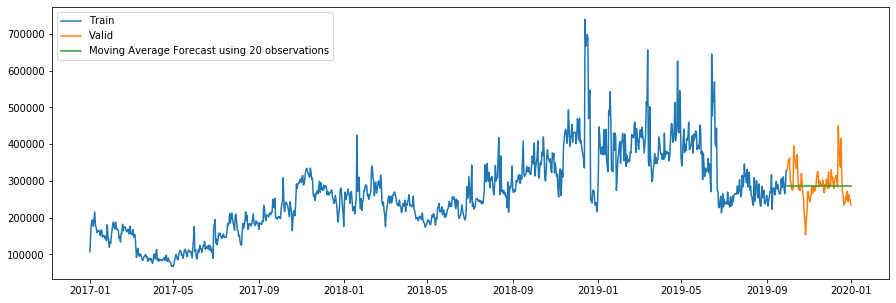

Root Mean Square Error: 47073.238807963586


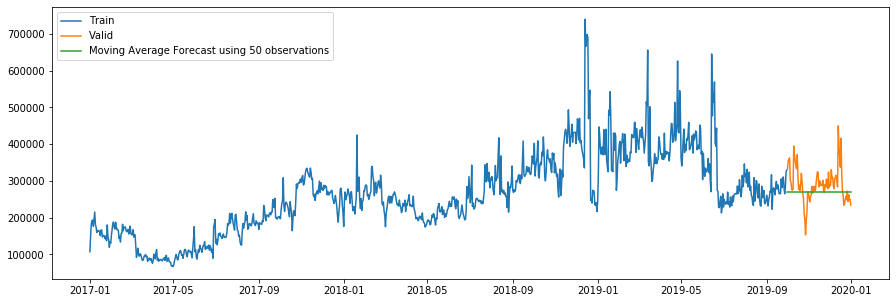

Root Mean Square Error: 51188.140438980656


In [21]:
# Lets try the rolling mean for last 10, 20, 50 days and visualize the results.

y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['gmv'].rolling(10).mean().iloc[-1] # average of last 10 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['gmv'], label='Train') 
plt.plot(valid['gmv'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show() 
rms = sqrt(mean_squared_error(valid.gmv, y_hat_avg.moving_avg_forecast)) 
print('Root Mean Square Error: '+ str(rms))

y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['gmv'].rolling(20).mean().iloc[-1] # average of last 20 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['gmv'], label='Train') 
plt.plot(valid['gmv'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations') 
plt.legend(loc='best') 
plt.show() 
rms = sqrt(mean_squared_error(valid.gmv, y_hat_avg.moving_avg_forecast)) 
print('Root Mean Square Error: '+ str(rms))

y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['gmv'].rolling(50).mean().iloc[-1] # average of last 50 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['gmv'], label='Train') 
plt.plot(valid['gmv'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show()
rms = sqrt(mean_squared_error(valid.gmv, y_hat_avg.moving_avg_forecast)) 
print('Root Mean Square Error: '+ str(rms))

#### We took the average of last 10, 20 and 50 observations and predicted based on that. This value can be changed in the above code in .rolling().mean() part. We can see that the predictions are getting weaker as we increase the number of observations.

### 3. Simple Exponential Smoothing
In this technique, we assign larger weights to more recent observations than to observations from the distant past.
The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

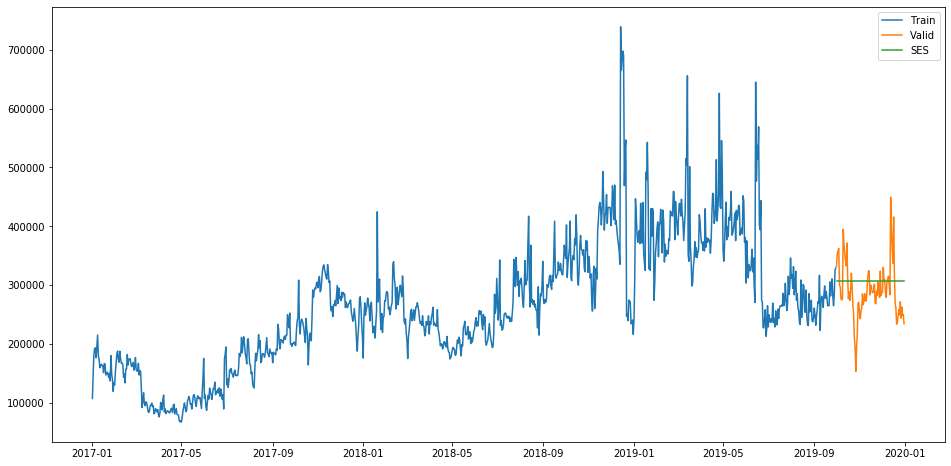

Root Mean Square Error: 49119.78470109775


In [22]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train['gmv'])).fit(smoothing_level=0.3,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['gmv'], label='Train') 
plt.plot(valid['gmv'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid.gmv, y_hat_avg.SES)) 
print('Root Mean Square Error: '+ str(rms))

### 4. Holt’s Linear Trend Model
It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.
First of all let us visualize the trend, seasonality and error in the series.

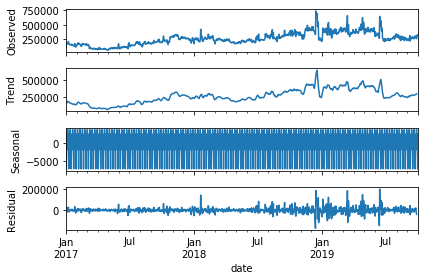

<Figure size 1152x576 with 0 Axes>

In [23]:
import statsmodels.api as sm 
sm.tsa.seasonal_decompose(Train.gmv).plot() 
result = sm.tsa.stattools.adfuller(Train.gmv) 
plt.figure(figsize=(16,8)) 
plt.show()

#### An increasing trend can be seen in the dataset, so now we will make a model based on the trend.

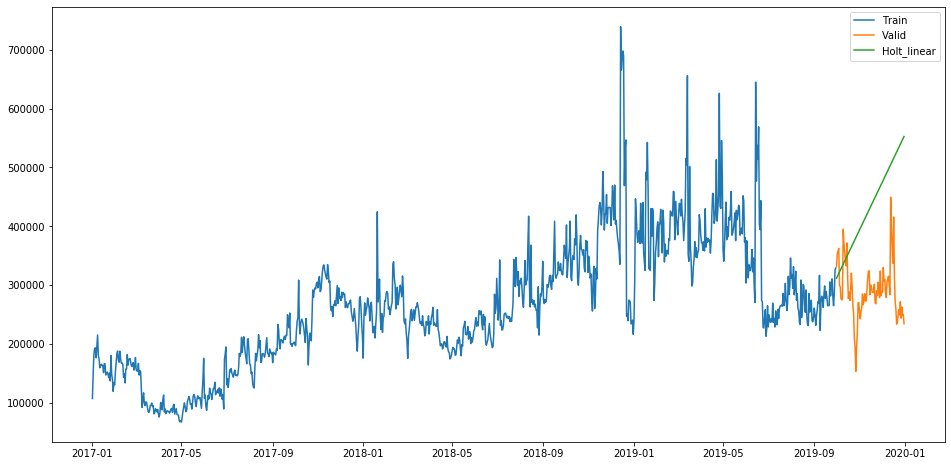

Root Mean Square Error: 166505.60200291753


In [24]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(Train['gmv'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['gmv'], label='Train') 
plt.plot(valid['gmv'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid.gmv, y_hat_avg.Holt_linear)) 
print('Root Mean Square Error: '+ str(rms))

C:\Users\Bhushan Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


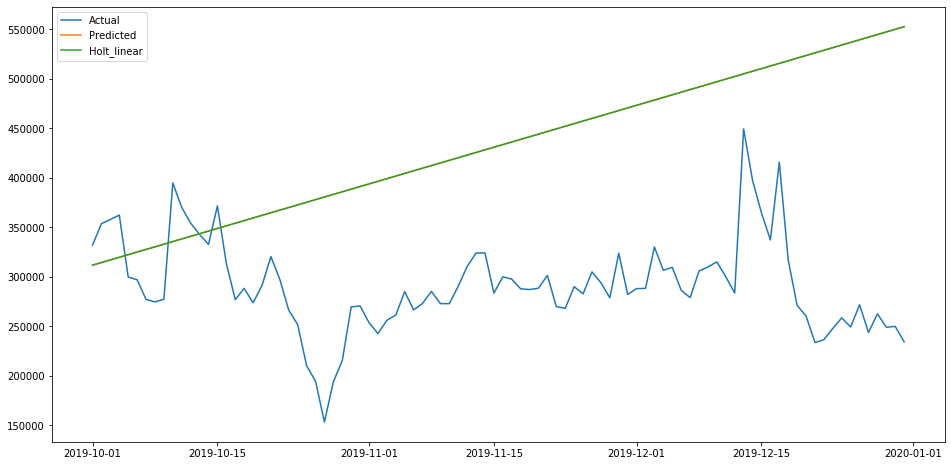

In [25]:
# # We only need ID and corresponding gmv for the final submission.
# # Let’s make prediction for the test dataset.
predict=fit1.forecast(len(valid))

# # Let’s save these predictions in test file in a new column.
valid['prediction']=predict
valid.head()

plt.figure(figsize=(16,8)) 
plt.plot(valid['gmv'], label='Actual') 
plt.plot(valid['prediction'], label='Predicted') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

### 5. Holt winter’s model on daily time series

#### Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.

The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.

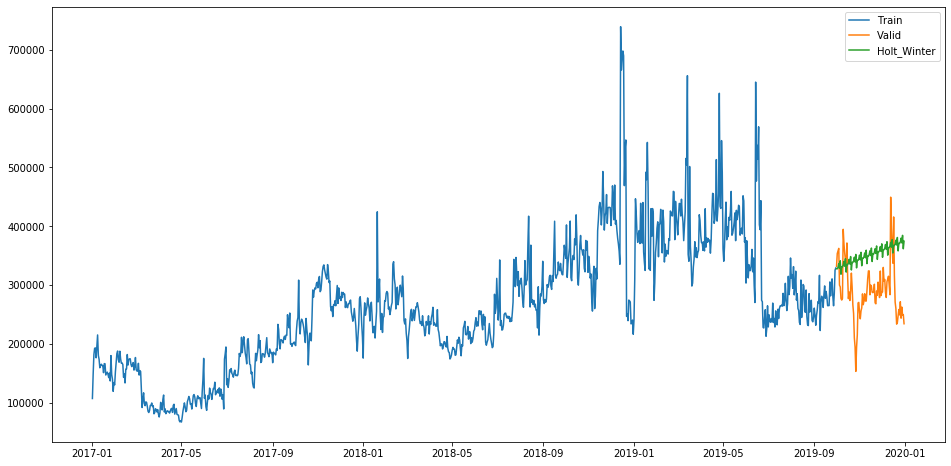

Root Mean Square Error: 78908.26704142737


In [26]:
# Let’s first fit the model on training dataset and validate it using the validation dataset.

y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['gmv']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['gmv'], label='Train') 
plt.plot(valid['gmv'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

rms = sqrt(mean_squared_error(valid.gmv, y_hat_avg.Holt_Winter)) 
print('Root Mean Square Error: '+ str(rms))

C:\Users\Bhushan Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


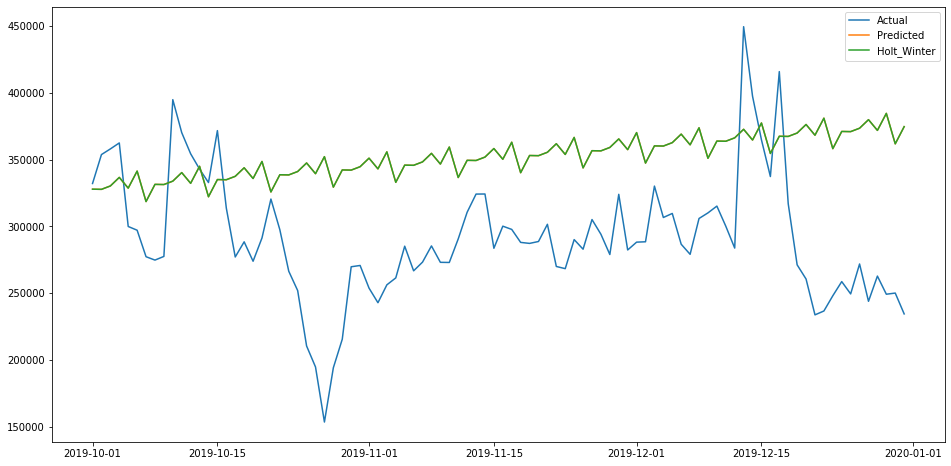

In [27]:
# # We only need ID and corresponding Count for the final submission.
# # Let’s make prediction for the test dataset.
predict=fit1.forecast(len(valid))

# # Let’s save these predictions in test file in a new column.
valid['prediction']=predict

plt.figure(figsize=(16,8)) 
plt.plot(valid['gmv'], label='Actual') 
plt.plot(valid['prediction'], label='Predicted') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

### 6. ARIMA

#### Introduction to ARIMA model
ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q).

Here p is the order of the autoregressive model(number of time lags)

d is the degree of differencing(number of times the data have had past values subtracted)

q is the order of moving average model. We will discuss more about these parameters in next section.

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

#### What is a stationary time series?
There are three basic criterion for a series to be classified as stationary series :

The mean of the time series should not be a function of time. It should be constant.

The variance of the time series should not be a function of time.

THe covariance of the ith term and the (i+m)th term should not be a function of time.

#### Why do we have to make the time series stationary?
We make the series stationary to make the variables independent. Variables can be dependent in various ways, but can only be independent in one way. So, we will get more information when they are independent. Hence the time series must be stationary.

If the time series is not stationary, firstly we have to make it stationary. For doing so, we need to remove the trend and seasonality from the data. 

### Parameter tuning for ARIMA model

First of all we have to make sure that the time series is stationary. If the series is not stationary, we will make it stationary.

Stationarity Check
We use Dickey Fuller test to check the stationarity of the series.
The intuition behind this test is that it determines how strongly a time series is defined by a trend.
The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

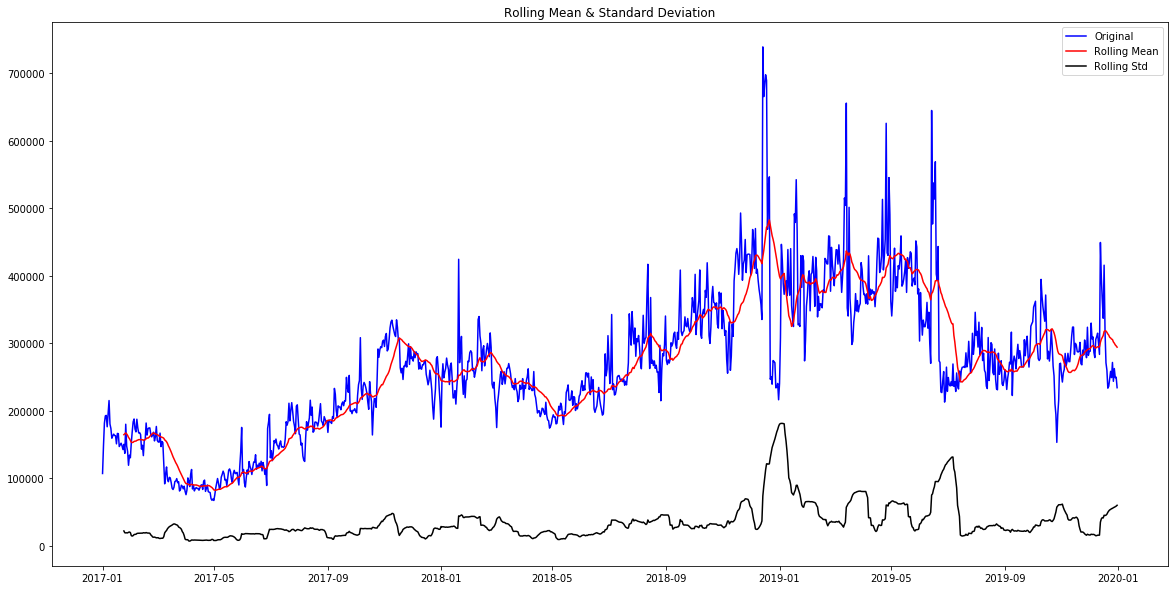

Results of Dickey-Fuller Test:
Test Statistic                   -2.163245
p-value                           0.219855
#Lags Used                       15.000000
Number of Observations Used    1079.000000
Critical Value (1%)              -3.436425
Critical Value (5%)              -2.864222
Critical Value (10%)             -2.568198
dtype: float64


In [28]:
# Let’s make a function which we can use to calculate the results of Dickey-Fuller test.

from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(train['gmv'])

#### The statistics shows that the time series is not stationary as Test Statistic < Critical value. So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.

### Removing Trend
A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.

We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.

We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.

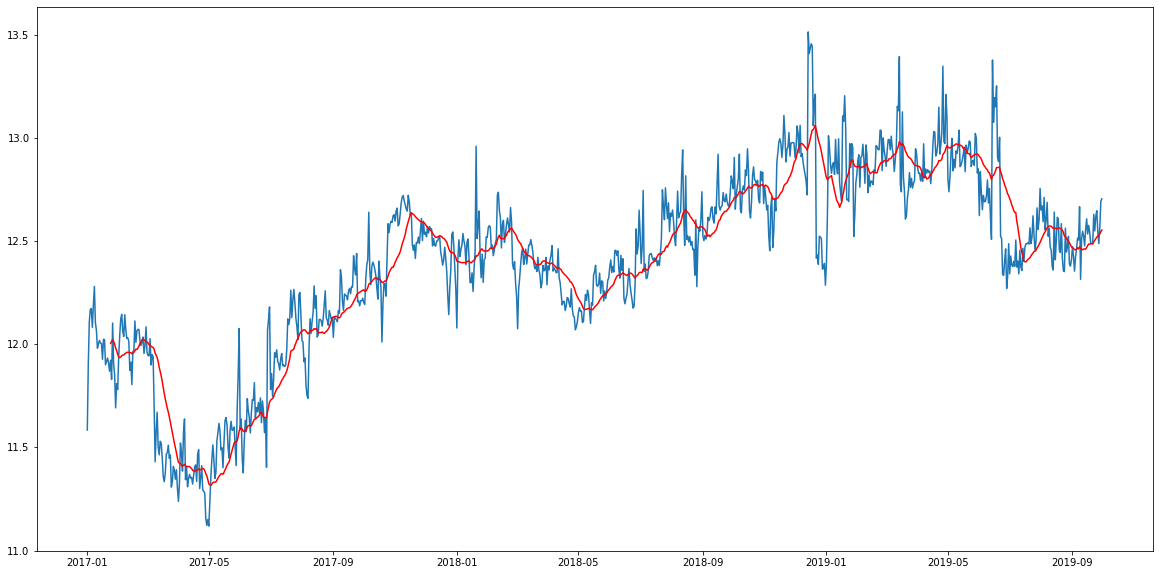

In [29]:
Train_log = np.log(Train['gmv']) 
valid_log = np.log(valid['gmv'])
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

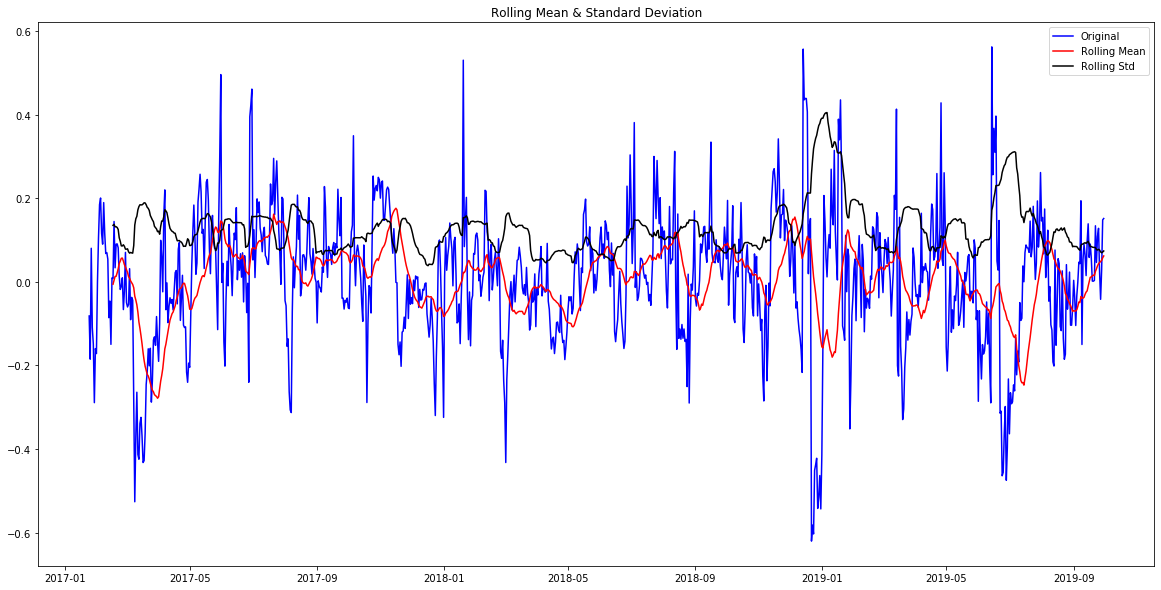

Results of Dickey-Fuller Test:
Test Statistic                -8.668415e+00
p-value                        4.616600e-14
#Lags Used                     7.000000e+00
Number of Observations Used    9.720000e+02
Critical Value (1%)           -3.437096e+00
Critical Value (5%)           -2.864518e+00
Critical Value (10%)          -2.568356e+00
dtype: float64


In [30]:
# So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.
train_log_moving_avg_diff = Train_log - moving_avg

# Since we took the average of 24 values, rolling mean is not defined for the first 23 values. So let’s drop those null values.
train_log_moving_avg_diff.dropna(inplace = True) 
test_stationarity(train_log_moving_avg_diff)

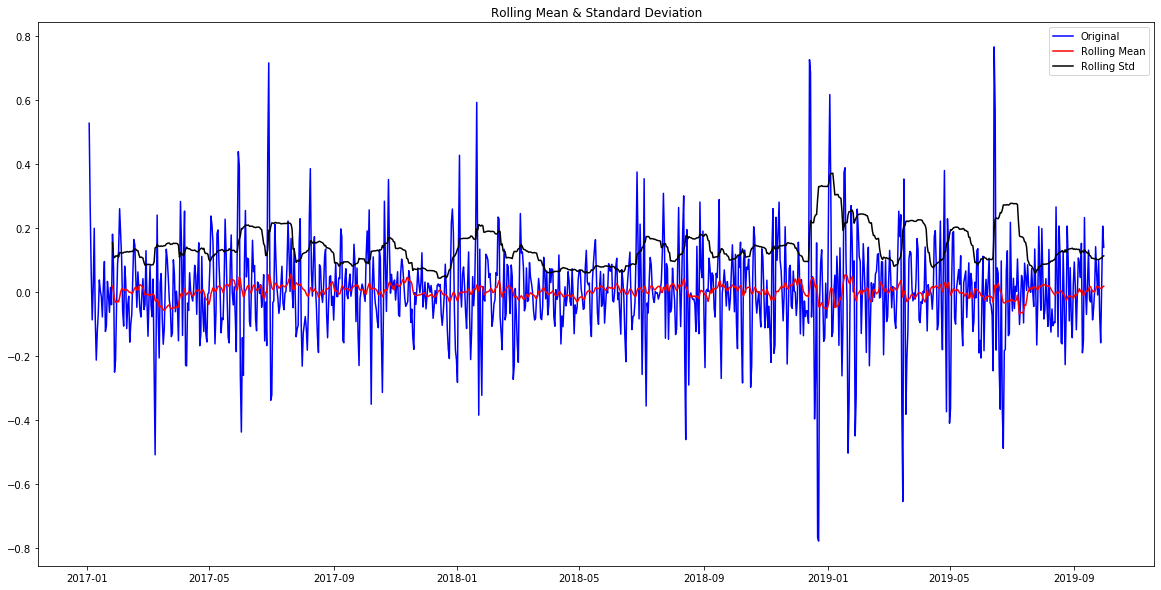

Results of Dickey-Fuller Test:
Test Statistic                -7.448302e+00
p-value                        5.759635e-11
#Lags Used                     2.200000e+01
Number of Observations Used    9.780000e+02
Critical Value (1%)           -3.437054e+00
Critical Value (5%)           -2.864500e+00
Critical Value (10%)          -2.568346e+00
dtype: float64


In [31]:
# Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.
# Differencing can help to make the series stable and eliminate the trend.

train_log_diff = Train_log - Train_log.shift(2) 
test_stationarity(train_log_diff.dropna())

#### Now we will decompose the time series into trend and seasonality and will get the residual which is the random variation in the series.

### Removing Seasonality
By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
Seasonality is always of a fixed and known period. We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.

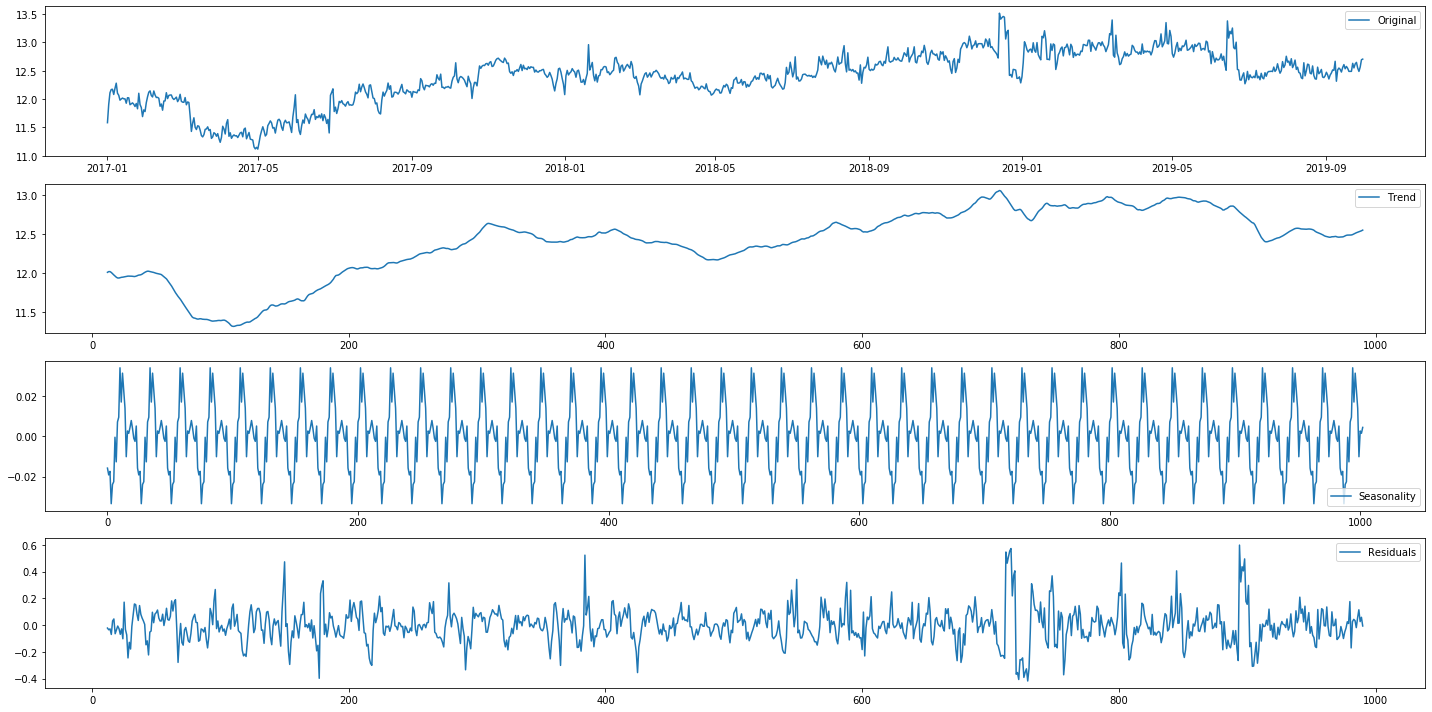

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(Train_log).gmv.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

#### We can see the trend, residuals and the seasonality clearly in the above graph. Seasonality shows a constant trend in counter.

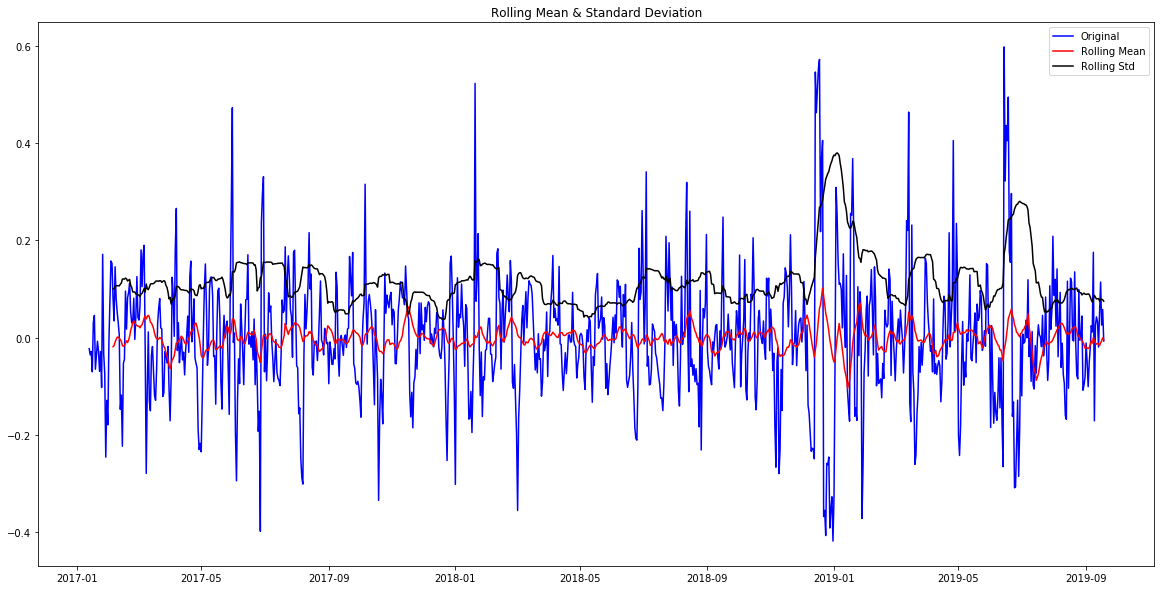

Results of Dickey-Fuller Test:
Test Statistic                -1.053708e+01
p-value                        8.843900e-19
#Lags Used                     2.100000e+01
Number of Observations Used    9.570000e+02
Critical Value (1%)           -3.437202e+00
Critical Value (5%)           -2.864565e+00
Critical Value (10%)          -2.568381e+00
dtype: float64


In [33]:
# Let’s check stationarity of residuals.

train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = Train_log.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

### Forecasting the time series using ARIMA
First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters.
To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [34]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

C:\Users\Bhushan Agarwal\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


### ACF and PACF plot

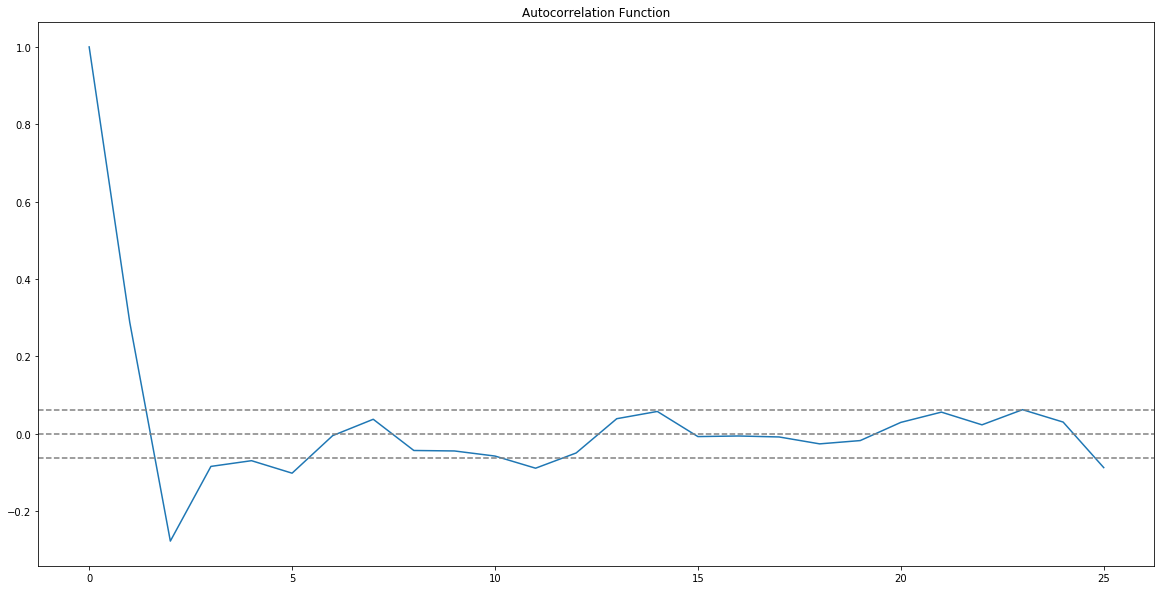

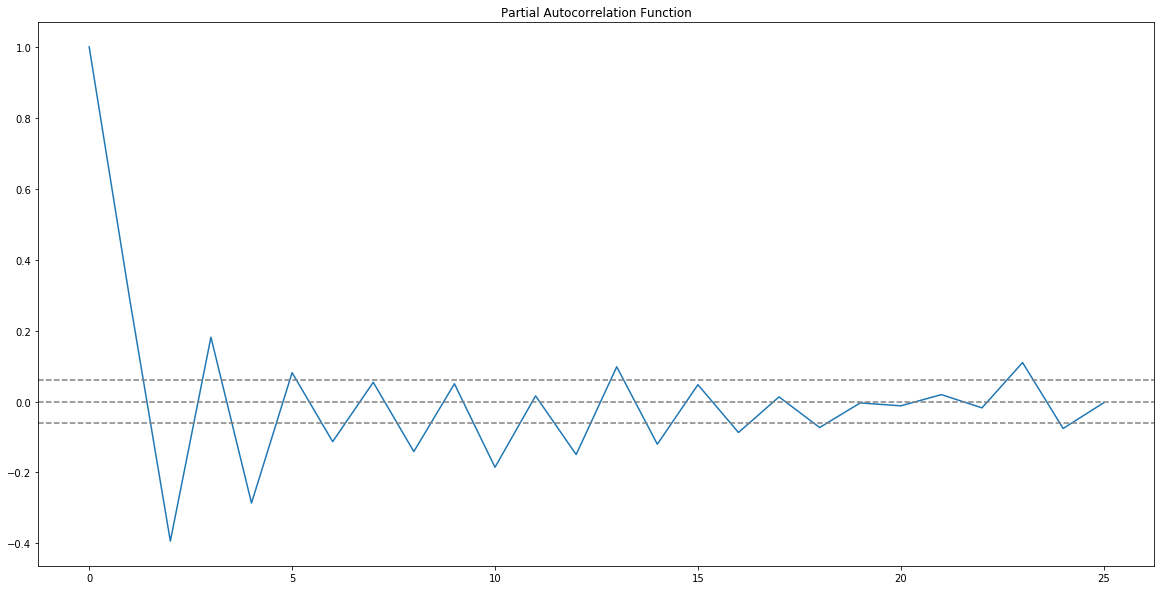

In [35]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

#### p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.
q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.

Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

### AR model
The autoregressive model specifies that the output variable depends linearly on its own previous values.

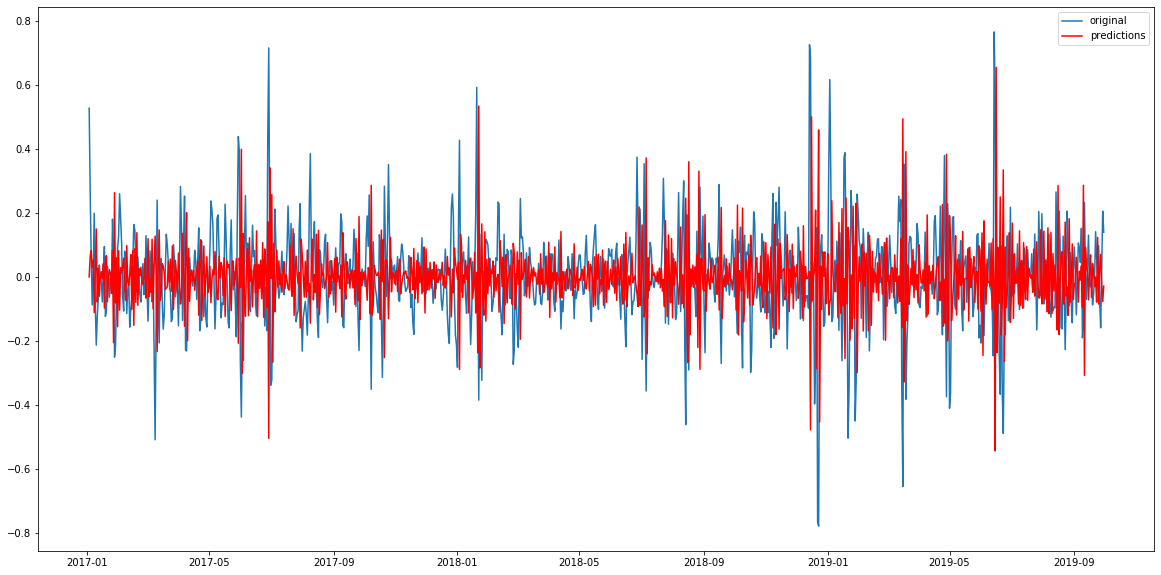

In [36]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order=(1, 2, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

### Lets plot the validation curve for AR model.
We have to change the scale of the model to the original scale.

First step would be to store the predicted results as a separate series and observe it.

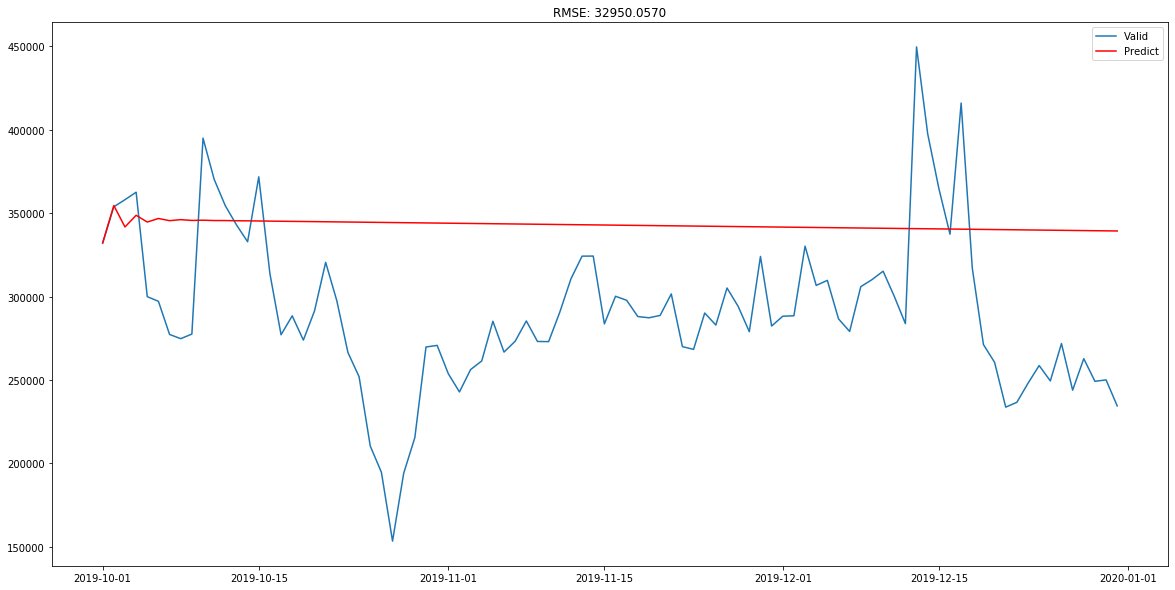

Here the red line shows the prediction for the validation set. Let’s build the MA model now.


In [37]:
AR_predict=results_AR.predict(start="2019-10-01", end="2019-12-31") 
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['gmv'])[0], index = valid.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)
plt.plot(valid['gmv'], label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['gmv']))/valid.shape[0])) 
plt.show()
print("Here the red line shows the prediction for the validation set. Let’s build the MA model now.")

### MA model
The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term

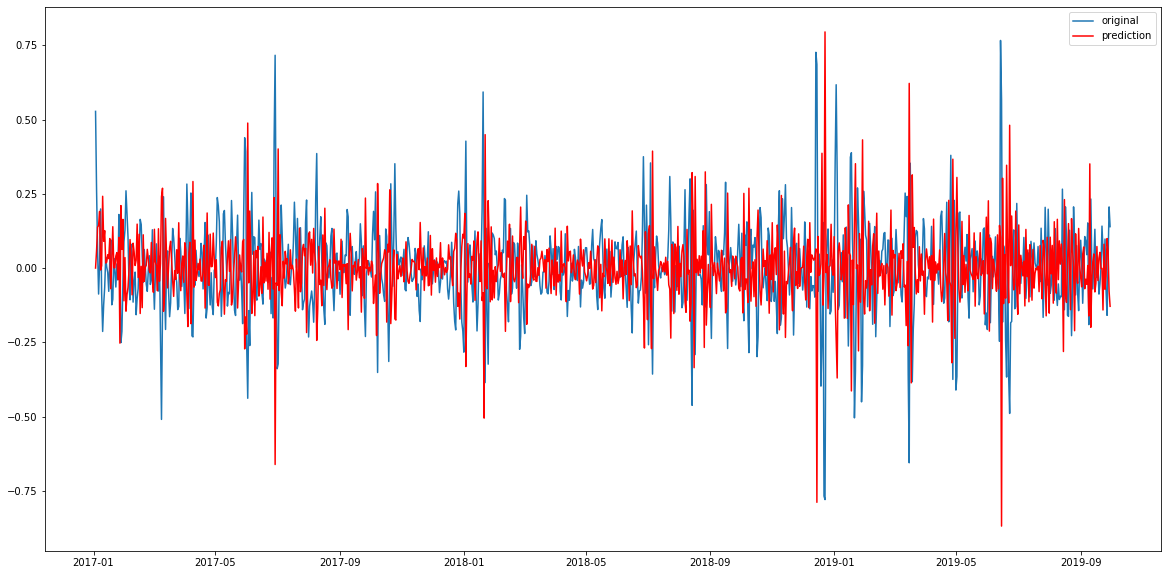

In [38]:
model = ARIMA(Train_log, order=(0, 2, 1))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

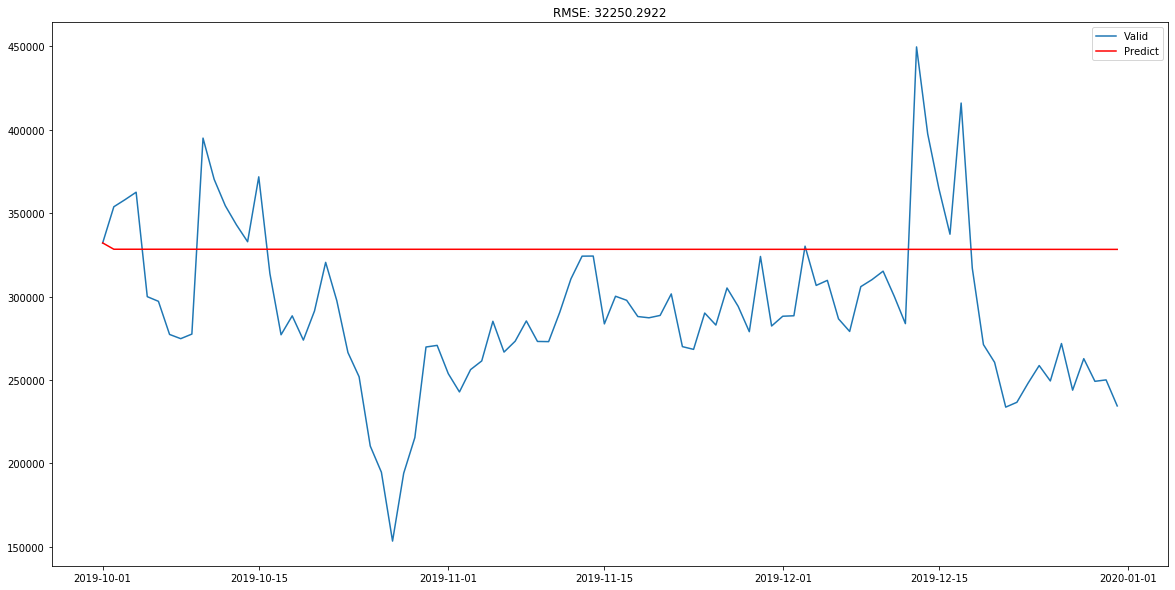

Now let’s combine these two models.


In [39]:
MA_predict=results_MA.predict(start="2019-10-01", end="2019-12-31") 
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['gmv'])[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)
plt.plot(valid['gmv'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['gmv']))/valid.shape[0])) 
plt.show()
print("Now let’s combine these two models.")

### Combined model

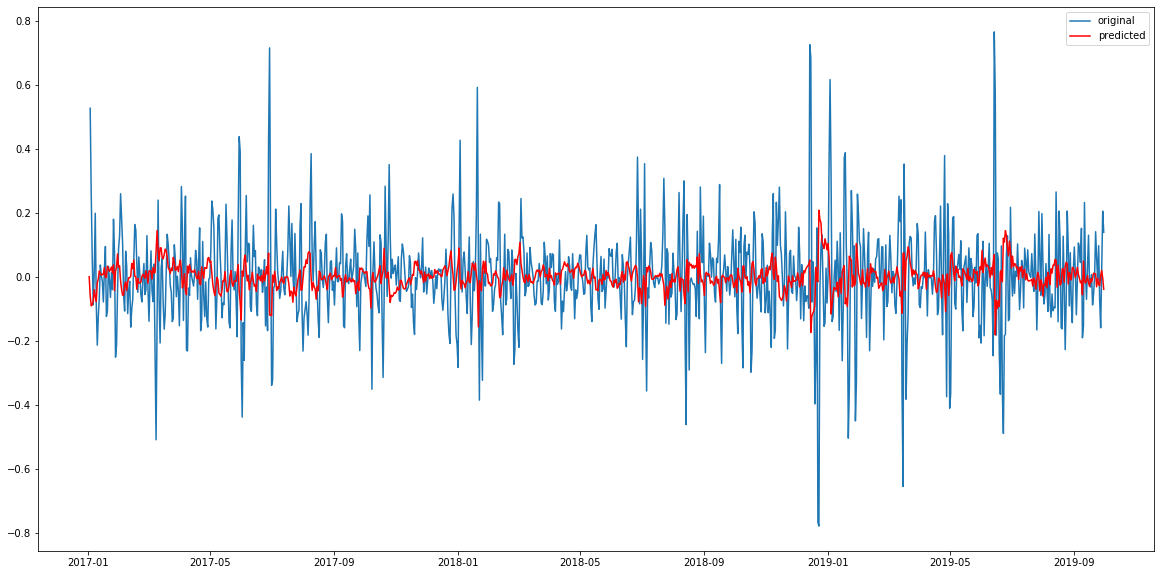

In [40]:
model = ARIMA(Train_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

In [41]:
# Let’s define a function which can be used to change the scale of the model to the original scale.

def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['gmv'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set['gmv'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['gmv']))/given_set.shape[0]))
    plt.show()
    
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plt.plot(given_set['gmv'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['gmv']))/given_set.shape[0]))
    plt.show()

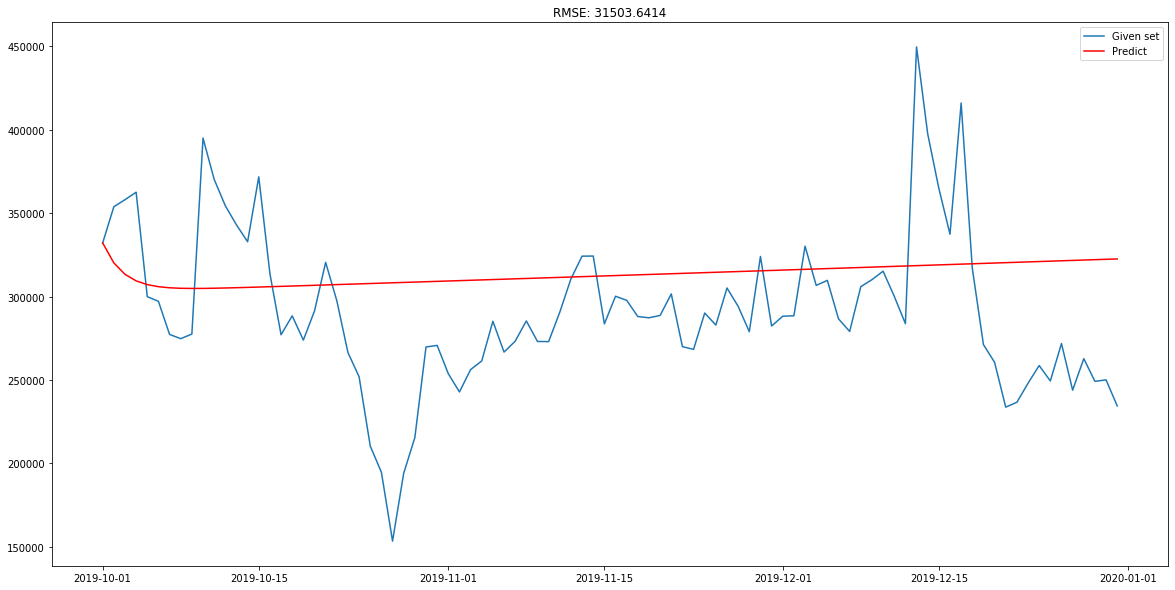

In [42]:
# Let’s predict the values for validation set.

ARIMA_predict_diff=results_ARIMA.predict(start="2019-10-01", end="2019-12-31")
check_prediction_diff(ARIMA_predict_diff, valid)

### 7. SARIMAX model on daily time series
SARIMAX model takes into account the seasonality of the time series. So we will build a SARIMAX model on the time series.

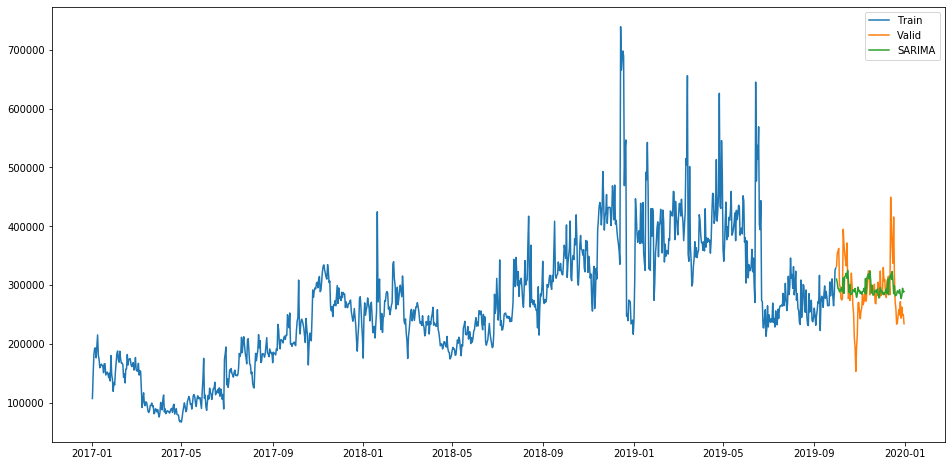

Root Mean Square Error: 42614.434690089365


In [43]:
import statsmodels.api as sm
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.gmv, order=(1, 1, 1),seasonal_order=(0,1,1,30)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2019-10-01", end="2019-12-31", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['gmv'], label='Train') 
plt.plot(valid['gmv'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

# Let’s check the rmse value for the validation part.

rms = sqrt(mean_squared_error(valid.gmv, y_hat_avg.SARIMA)) 
print('Root Mean Square Error: '+ str(rms))

#### Order in the above model represents the order of the autoregressive model(number of time lags), the degree of differencing(number of times the data have had past values subtracted) and the order of moving average model.

Seasonal order represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

In our case the periodicity is 7 since it is daily time series and will repeat after every 7 days.

C:\Users\Bhushan Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


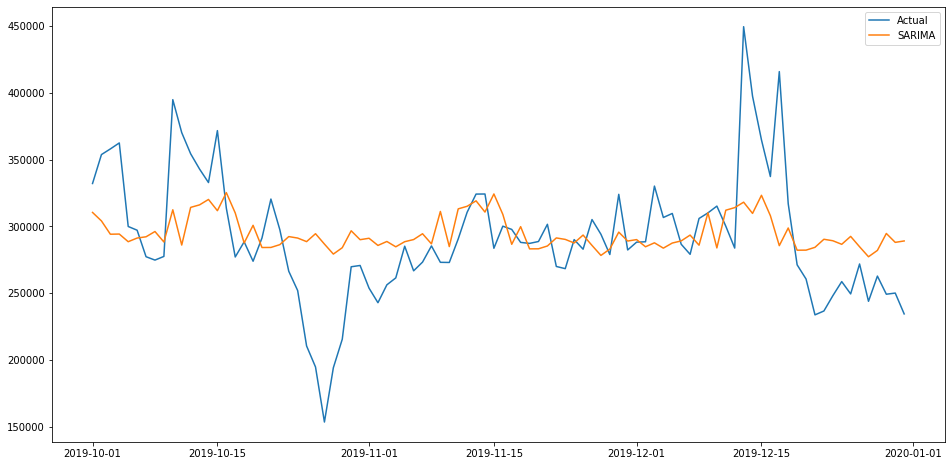

In [44]:
# # We only need ID and corresponding Count for the final submission.
# # Let’s make prediction for the test dataset.
predict=fit1.forecast(len(valid))

# # Let’s save these predictions in test file in a new column.
valid['prediction']=predict

plt.figure(figsize=(16,8)) 
plt.plot(valid['gmv'], label='Actual') 
# plt.plot(valid['prediction'], label='Predicted') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

### Grid search for parameters

In [45]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 30)
SARIMAX: (0, 0, 1) x (0, 1, 0, 30)
SARIMAX: (0, 1, 0) x (0, 1, 1, 30)
SARIMAX: (0, 1, 0) x (1, 0, 0, 30)


In [46]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(Train.gmv,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{}30 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 30)30 - AIC:28010.36270360156
ARIMA(0, 0, 0)x(0, 0, 1, 30)30 - AIC:26609.79274869638
ARIMA(0, 0, 0)x(0, 1, 0, 30)30 - AIC:24558.905366006904
ARIMA(0, 0, 0)x(0, 1, 1, 30)30 - AIC:23697.105538244847
ARIMA(0, 0, 0)x(1, 0, 0, 30)30 - AIC:24576.41059087486
ARIMA(0, 0, 0)x(1, 0, 1, 30)30 - AIC:24447.42809354108
ARIMA(0, 0, 0)x(1, 1, 0, 30)30 - AIC:23750.655666938765
ARIMA(0, 0, 0)x(1, 1, 1, 30)30 - AIC:23695.884131258143
ARIMA(0, 0, 1)x(0, 0, 0, 30)30 - AIC:27290.01887858954
ARIMA(0, 0, 1)x(0, 0, 1, 30)30 - AIC:26313.5015960264
ARIMA(0, 0, 1)x(0, 1, 0, 30)30 - AIC:24123.679680863497
ARIMA(0, 0, 1)x(0, 1, 1, 30)30 - AIC:23266.714916278088
ARIMA(0, 0, 1)x(1, 0, 0, 30)30 - AIC:26265.8861643149
ARIMA(0, 0, 1)x(1, 0, 1, 30)30 - AIC:26207.853743214706
ARIMA(0, 0, 1)x(1, 1, 0, 30)30 - AIC:23356.615337832507
ARIMA(0, 0, 1)x(1, 1, 1, 30)30 - AIC:23266.971423536925
ARIMA(0, 1, 0)x(0, 0, 0, 30)30 - AIC:24075.430326280304
ARIMA(0, 1, 0)x(0, 0, 1, 30)30 - AIC:23368.256143598395
A

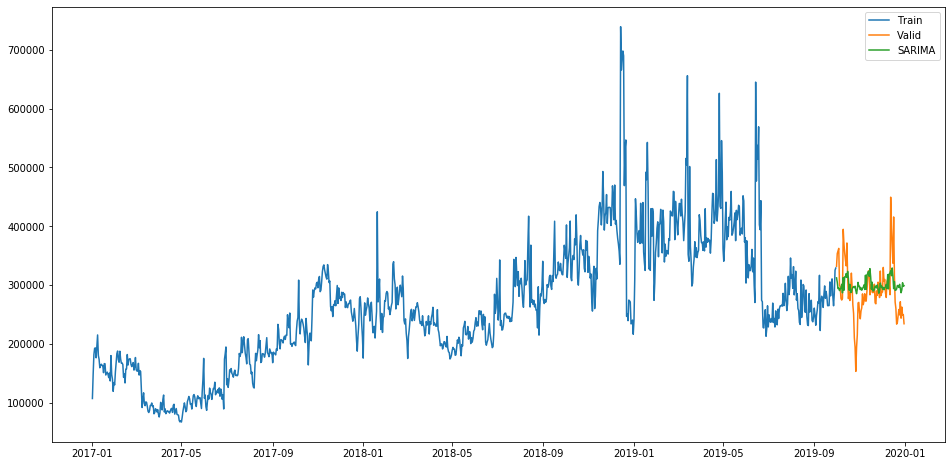

In [47]:
import statsmodels.api as sm
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.gmv, order=(1, 1, 1),seasonal_order=(1,1,1,30)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2019-10-01", end="2019-12-31", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['gmv'], label='Train') 
plt.plot(valid['gmv'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

In [48]:
print(fit1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6184      0.044     14.146      0.000       0.533       0.704
ma.L1         -0.9086      0.026    -35.115      0.000      -0.959      -0.858
ar.S.L30       0.0828      0.060      1.374      0.169      -0.035       0.201
ma.S.L30      -0.9127      0.028    -32.439      0.000      -0.968      -0.858
sigma2      2.657e+09   1.08e-11   2.45e+20      0.000    2.66e+09    2.66e+09


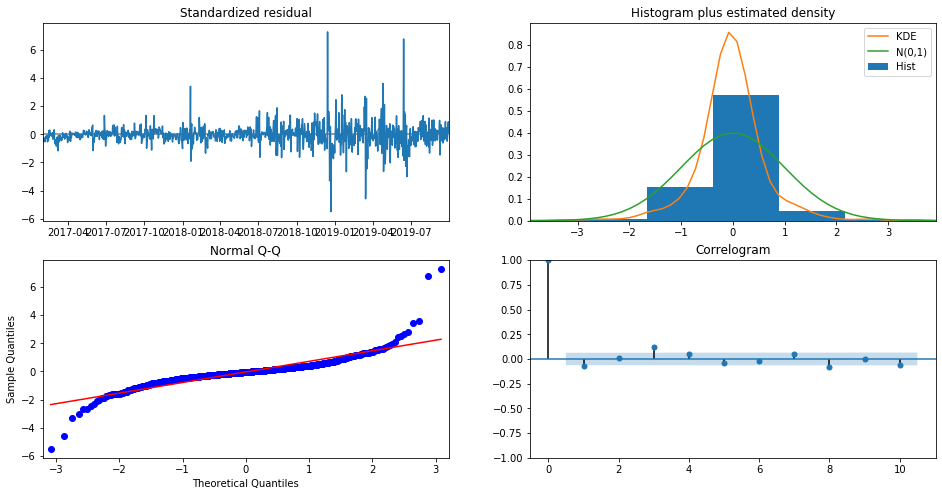

In [49]:
fit1.plot_diagnostics(figsize=(16, 8))
plt.show()

C:\Users\Bhushan Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


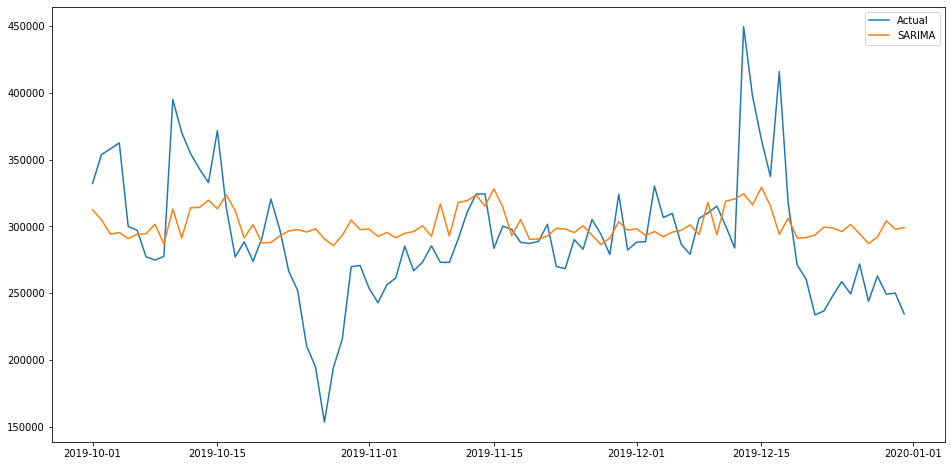

Root Mean Square Error: 44257.84497604443


In [51]:
# # We only need ID and corresponding Count for the final submission.
# # Let’s make prediction for the test dataset.
predict=fit1.forecast(len(valid))

# # Let’s save these predictions in test file in a new column.
valid['prediction']=predict

plt.figure(figsize=(16,8)) 
plt.plot(valid['gmv'], label='Actual') 
# plt.plot(valid['prediction'], label='Predicted') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

# Let’s check the rmse value for the validation part.

rms = sqrt(mean_squared_error(valid.gmv, y_hat_avg.SARIMA)) 
print('Root Mean Square Error: '+ str(rms))